# Summary

By using 2 thigh IMUs and 1 torso imu, we could achieve 90.5% . 
Classification into 7 classes VS regression: Regression model showed better performance 
By building subject specific models, we can achieve very accurate model. Interestingly, classification into 7 classes showed better performance over regression for subject specific model.



Best models, performance measures for each case

- Classification into 3 classes: Random Forest, Test Accuracy(90.5%)

- Classification into 7 classes: Random Forest, Test Accuracy(54.2%)

- Regression: Linear Regression (with 90% variance explained PCA components), Test R2 score(0.947), Converted Test Accuracy(75.4%)


For practical implementation, we made subject-specific models for each case 

- Classification into 3 classes: Random Forest, Test Accuracy(99.9%)

- Classification into 7 classes: Random Forest, Test Accuracy(99.2%)

- Regression: Linear Regression (with 90% variance explained PCA components), Converted Test Accuracy(93.0%)



In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm
import itertools;
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from itertools import product
from collections import OrderedDict   
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from matplotlib import colors
import seaborn as sns
import time

%matplotlib inline

sns.set_context("poster")

! pip install colour
from colour import Color
red = Color("blue")
colors = list(red.range_to(Color("green"),7))

/Users/personalmac/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Reading and Cleaning Data

In [3]:
### READING DATA

df = pd.read_csv('dataAll_csv8_withmm.csv')
df["slope_class"] = 0
df["slope_class"][df['ref_slope'] < 0] = -1
df["slope_class"][df['ref_slope'] == 0]= 0
df["slope_class"][df['ref_slope'] > 0]= 1
df = df.drop("ref_speed", axis=1)


/Users/personalmac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/personalmac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/personalmac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [4]:
# Train/Test set split for Leave One Subject Out Cross Validation

subject_test = 6;

df_train = df[df['subject_number'] != subject_test]
df_test = df[df['subject_number'] ==subject_test]


In [5]:
# Cleaning data: 

# y_train (3 classes) : uphill / flat / downhill 
# y_train_multi (7 classes) : -10%/ -5% / 0% / 5% / 10% / 15%/ 20%

X_train = df_train.iloc[:, :-2]
y_train = df_train.iloc[:, -1]
y_train_multi = df_train.iloc[:, -2]

X_test = df_test.iloc[:, :-2]
y_test = df_test.iloc[:, -1]
y_test_multi = df_test.iloc[:, -2]


### Remove unnecessary predictors (Time, Angle Z, Accerelation X and Y)

for i in range(df_train.shape[1]):
    if df_train.columns[i] == 'timeGaitExt_L_0':
        break
        
index_unused_features = i



# IMU Data

a = 52
X_train = df_train[df_train.columns[a:a+107]].copy()
X_test = df_test[df_test.columns[a:a+107]].copy()
a += 107

while a < index_unused_features:
    
    # IMU data except angle Z, acc X, acc Y 

    if not ((df_train.columns[a].split('_')[0] == 'angleZ') or (df_train.columns[a].split('_')[0] == 'accXRot') or (df_train.columns[a].split('_')[0] == 'accYRot')):
        X_train = pd.concat([X_train, df_train[df_train.columns[a:a+107]]], axis =1)
        X_test = pd.concat([X_test, df_test[df_test.columns[a:a+107]]], axis =1)

    a += 107
    
# subject Height, Weight
X_train = pd.concat([X_train, df_train[df_train.columns[-4:-2]]], axis =1)
X_test = pd.concat([X_test, df_test[df_test.columns[-4:-2]]], axis =1)

# subject number
subnum_train = df_train[df_train.columns[0]].values
subnum_test = df_test[df_test.columns[0]].values

print("Number of predictors we have: %d" %X_train.shape[1])

Number of predictors we have: 1928


In [6]:
# standardize data
def standardize(x, x_ref):
    mean = np.mean(x_ref);
    std = np.std(x_ref);  

    x_stand = (x - mean)/std;
    return x_stand

X_train_unstand = X_train.copy();
X_train_std = standardize(X_train, X_train_unstand)

X_test_unstand = X_test.copy();
X_test_std = standardize(X_test, X_train_unstand)

### Custom Functions

In [7]:
def custom_cv(est_list, X, y, paramlist, subject_nums):    
    # iterate through each parameter with estimators premade
    # subject_list is the same order of df entries
    param_score_list = [];
    for e in est_list:
        
        # iterate through each fold
        fold_score_list = [0]*5;
        subject_list = list(set(subject_nums))
        
        for j, sub_num in enumerate(subject_list):
#             sub_num = j + 1 
            valid = subject_nums == sub_num
            train = subject_nums == sub_num
            Xtrain = X[train];
            ytrain = y[train];
            Xvalid = X[valid];
            yvalid = y[valid];
            
            # fit and validate
            e.fit(Xtrain, ytrain)
            fold_score_list[j] = e.score(Xvalid, yvalid)
        
        param_score_list.append(np.mean(fold_score_list))
                    
    i_best = np.argmax(param_score_list)
    
    # fit again on all train data
    best_est = est_list[i_best]
    best_est.fit(X, y)
    
    return paramlist[i_best], param_score_list[i_best], best_est

In [8]:
def subject_set(X, y, subject_num):
    X_list = []
    y_list = []
    
    subject_list = list(set(subject_num))
    
    for j, subject in enumerate(subject_list):

        subject_TF = subject_num == subject

        X_list.append(X[subject_TF]);
        y_list.append(y[subject_TF]);

        
    # split into test and train
    
    X_train_list = [None]*len(subject_list);
    X_test_list = [None]*len(subject_list);

    y_train_list = [None]*len(subject_list);
    y_test_list = [None]*len(subject_list);

    for j in range(0, len(X_list)):
        np.random.seed(9001)
        msk = np.random.rand(len(X_list[j])) < 0.75
        X_train_list[j] = X_list[j][msk]
        X_test_list[j] = X_list[j][~msk]

        y_train_list[j] = y_list[j][msk]
        y_test_list[j] = y_list[j][~msk]
    
    
    return X_train_list, y_train_list, X_test_list, y_test_list

In [9]:
def regression_to_classification(y_true, y_pred):

    y_class = np.zeros(len(y_pred))
    
    for i, prediction in enumerate(y_pred):
        if prediction < -7.5:
            y_class[i] = -10
        elif prediction >= -7.5 and prediction < -2.5:
            y_class[i] = -5
        elif prediction >= -2.5 and prediction < 2.5:
            y_class[i] = 0
        elif prediction >= 2.5 and prediction < 7.5:
            y_class[i] = 5
        elif prediction >= 7.5 and prediction < 12.5:
            y_class[i] = 10
        elif prediction >= 12.5 and prediction < 17.5:
            y_class[i] = 15            
        elif prediction >= 17.5:
            y_class[i] = 20            
        
    y_tf = y_class == y_true
    accuracy = np.sum(y_tf) / len(y_true)  
    
    return y_class, accuracy

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 1. Result

### 1) Classification into 3 classes (Uphill / Flat / Downhill)

Table: explanation

- Baseline model: plot
- Best model: plot, confusion matrix
- Individual Model: plots


In [19]:
# Baseline model: Decision Tree

dt_base = DecisionTreeClassifier(max_depth = None)
dt_base.fit(X_train, y_train)

score_base_train = dt_base.score(X_train, y_train)
score_base_test  = dt_base.score(X_test, y_test)


In [12]:
# Random Forest (Leave One Subject Out CV)

n_list = [8, 16, 32, 64];
est_list = [];
for n in n_list:
    rf = RandomForestClassifier(oob_score = True, n_estimators=n, max_features=int(np.sqrt(len(X_train.columns))) , n_jobs=-1)
    est_list.append(rf)
    

best_p, best_score, best_est_rf = custom_cv(est_list, X_train, y_train, n_list, subnum_train)
best_p, best_score

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

(16, 1.0)

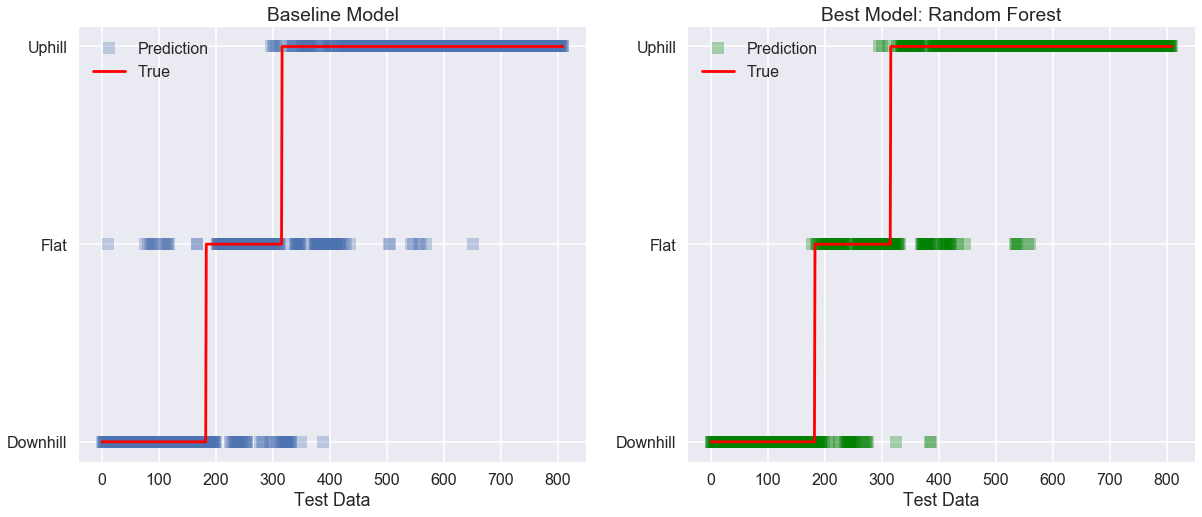

In [18]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
axes = axes.flatten()

axes[0].plot(np.arange(len(y_test)), dt_base.predict(X_test), 's', alpha = 0.3, label = 'Prediction')
axes[0].plot(np.arange(len(y_test)), y_test, 'r-', label = 'True')

axes[0].set_yticks( np.unique(y_test))
axes[0].set_yticklabels(['Downhill', 'Flat', 'Uphill'])

axes[0].set_xlabel("Test Data")
axes[0].set_title('Baseline Model')
axes[0].legend()



axes[1].plot(np.arange(len(y_test)), best_est_rf.predict(X_test), 'gs', alpha = 0.3, label = 'Prediction')
axes[1].plot(np.arange(len(y_test)), y_test, 'r-', label = 'True')

axes[1].set_yticks( np.unique(y_test))
axes[1].set_yticklabels(['Downhill', 'Flat', 'Uphill'])

axes[1].set_xlabel("Test Data")
axes[1].set_title("Best Model: Random Forest")
axes[1].legend()


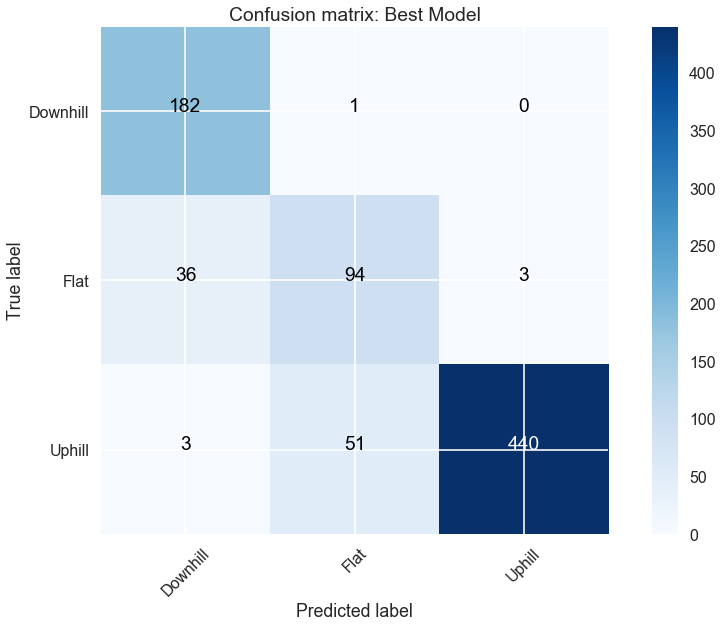

In [22]:
class_names = ['Downhill', 'Flat', 'Uphill']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, best_est_rf.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix: Best Model')

plt.show()

### Individual Mode: Random Forest

In [23]:
X_train_list, y_train_list, X_test_list, y_test_list= subject_set(X_train, y_train, subnum_train)

n_list = [2,8, 16, 32, 64]
rf_cv_ind_list = [None] * len(X_train_list)
score_rf_cv_train_list = [None] * len(X_train_list)
score_rf_cv_test_list = [None] * len(X_train_list)

for i in range(len(X_train_list)):

    rf_ind = RandomForestClassifier(oob_score = True, max_features=int(np.sqrt(len(X_train_list[i].columns))) , n_jobs=-1)
    n_est = {'n_estimators': n_list}
    rfGrid_ind  = GridSearchCV(rf_ind, n_est, cv = 5)
    rfGrid_ind.fit(X_train_list[i], y_train_list[i])


    rf_cv_ind = RandomForestClassifier(oob_score = True, n_estimators= rfGrid_ind.best_params_['n_estimators'], 
                                       max_features=int(np.sqrt(len(X_train_list[i].columns))) , n_jobs=-1)
    rf_cv_ind.fit(X_train_list[i], y_train_list[i])
    
    rf_cv_ind_list[i] = rf_cv_ind


    score_rf_cv_train_list[i] = rf_cv_ind.score(X_train_list[i], y_train_list[i])
    score_rf_cv_test_list[i] = rf_cv_ind.score(X_test_list[i], y_test_list[i])


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


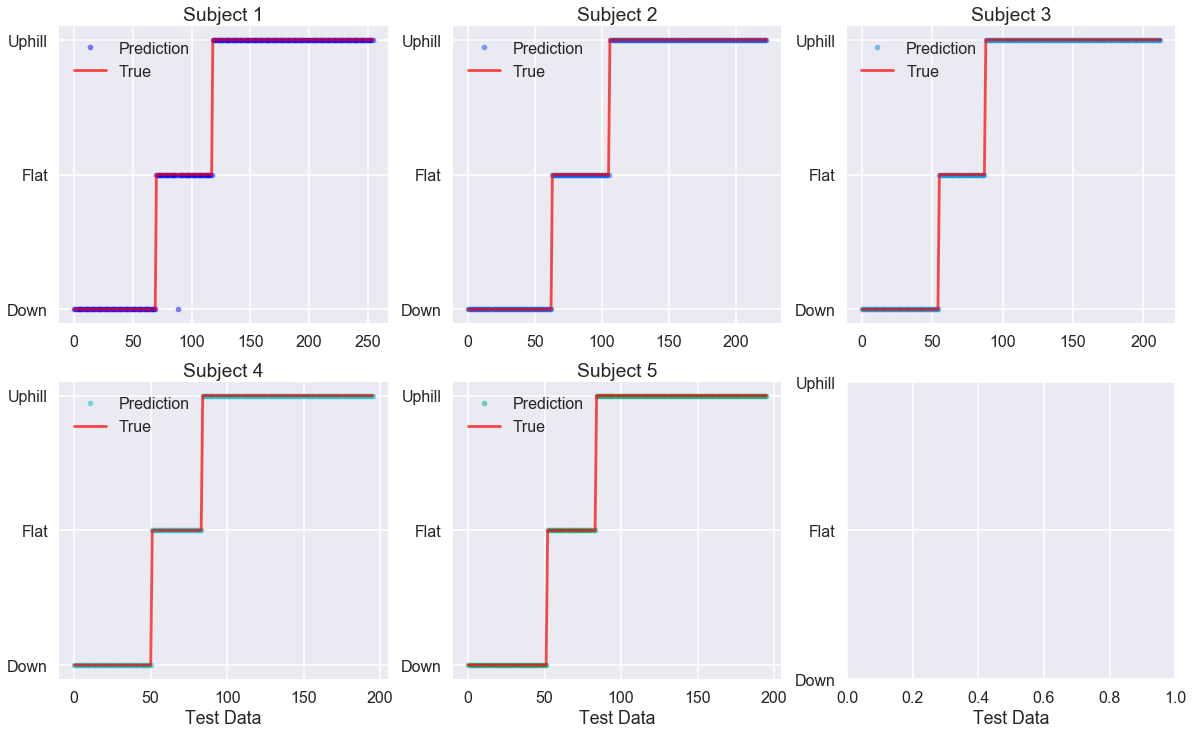

In [39]:
fig, axes = plt.subplots(2,3, figsize=(20,12))
axes = axes.flatten()

for i in range(len(X_train_list)):
    axes[i].plot(rf_cv_ind_list[i].predict(X_test_list[i]), '.', color= colors[i].get_rgb(), alpha = 0.5, label = 'Prediction')
    axes[i].plot(y_test_list[i].values, 'r-', alpha = 0.7, label = 'True')
    axes[i].set_title('Subject '+str(i+1))
    axes[i].legend()
    axes[i].set_yticks( np.unique(y_test))
    axes[i].set_yticklabels(['Down', 'Flat', 'Uphill'])



axes[3].set_xlabel("Test Data")
axes[4].set_xlabel("Test Data")
axes[5].set_xlabel("Test Data")

axes[5].set_yticks( np.unique(y_test))
axes[5].set_yticklabels(['Down', 'Flat', 'Uphill'])


plt.show()

### 2) Classification into 7 classes (-10, -5, 0, 5, 10, 15, 20)

Table: explanation

- Baseline model: plot
- Best model: plot, confusion matrix
- Individual Model: plots

-Baseline & best model: not very different -> inappropriate to build classification model

In [25]:
base_dt_m = DecisionTreeClassifier()
base_dt_m.fit(X_train, y_train_multi)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [26]:
n_list = [2,8, 16, 32, 64, 128];
est_list = [];
for n in n_list:
    rf = RandomForestClassifier(oob_score = True, n_estimators=n, max_features=int(np.sqrt(len(X_train.columns))) , n_jobs=-1)
    est_list.append(rf)
    

best_p, best_score, best_est_rf_m = custom_cv(est_list, X_train, y_train_multi, n_list, subnum_train)
best_p, best_score

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

(32, 1.0)

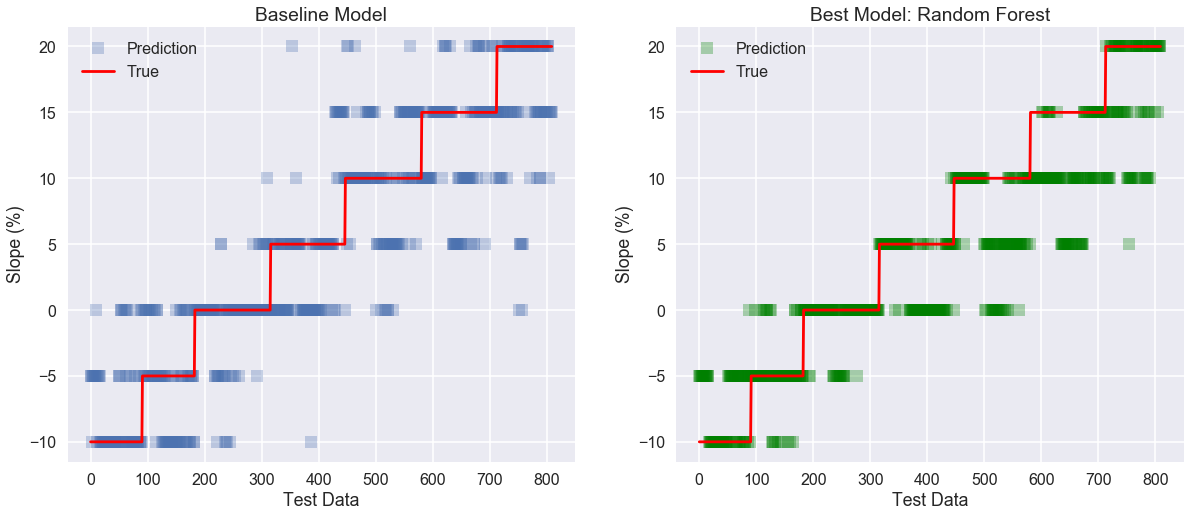

In [27]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
axes = axes.flatten()

axes[0].plot(np.arange(len(y_test)), base_dt_m.predict(X_test), 's', alpha = 0.3, label = 'Prediction')
axes[0].plot(np.arange(len(y_test)), y_test_multi, 'r-', label = 'True')

axes[0].set_xlabel("Test Data")
axes[0].set_ylabel("Slope (%)")
axes[0].set_title('Baseline Model')
axes[0].legend()


axes[1].plot(np.arange(len(y_test)), best_est_rf_m.predict(X_test), 'gs', alpha = 0.3, label = 'Prediction')
axes[1].plot(np.arange(len(y_test)), y_test_multi, 'r-', label = 'True')

axes[1].set_xlabel("Test Data")
axes[1].set_ylabel("Slope (%)")
axes[1].set_title("Best Model: Random Forest")
axes[1].legend()



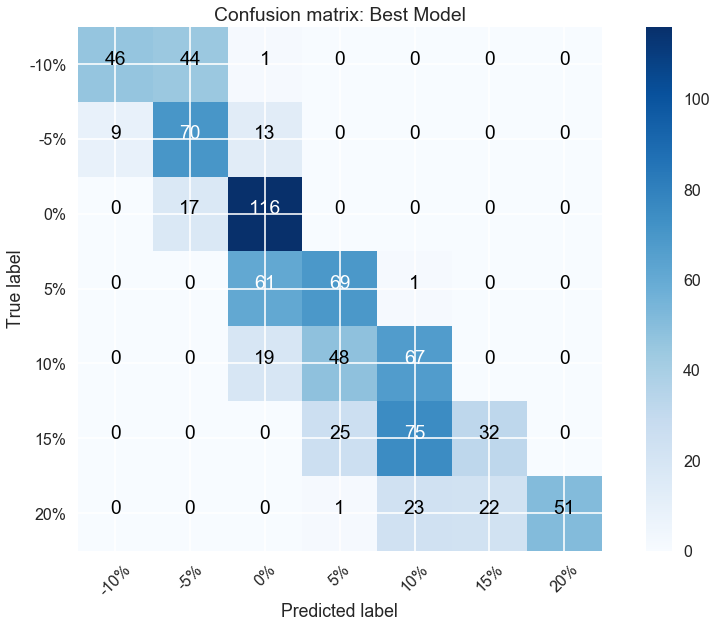

In [29]:
class_names = ['-10%', '-5%', '0%', '5%', '10%', '15%', '20%']

# Compute confusion matrix
cnf_matrix_mt = confusion_matrix(y_test_multi, best_est_rf_m.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_mt, classes=class_names,
                      title='Confusion matrix: Best Model')


### Individual Models (Random Forest)

In [30]:
X_train_list_n, y_train_multi_list_n, X_test_list_n, y_test_multi_list_n= subject_set(X_train, y_train_multi, subnum_train)

n_list = [2,8, 16, 32, 64]
rf_cv_ind_list_n = [None] * len(X_train_list_n)
score_rf_cv_train_list_n = [None] * len(X_train_list_n)
score_rf_cv_test_list_n = [None] * len(X_train_list_n)

for i in range(len(X_train_list_n)):

    rf_ind_n = RandomForestClassifier(oob_score = True, max_features=int(np.sqrt(len(X_train_list_n[i].columns))) , n_jobs=-1)
    n_est = {'n_estimators': n_list}
    rfGrid_ind_n  = GridSearchCV(rf_ind_n, n_est, cv = 5)
    rfGrid_ind_n.fit(X_train_list_n[i], y_train_multi_list_n[i])


    rf_cv_ind_n = RandomForestClassifier(oob_score = True, n_estimators= rfGrid_ind_n.best_params_['n_estimators'], 
                                       max_features=int(np.sqrt(len(X_train_list_n[i].columns))) , n_jobs=-1)
    rf_cv_ind_n.fit(X_train_list_n[i], y_train_multi_list_n[i])
    
    rf_cv_ind_list_n[i] = rf_cv_ind_n


    score_rf_cv_train_list_n[i] = rf_cv_ind_n.score(X_train_list_n[i], y_train_multi_list_n[i])
    score_rf_cv_test_list_n[i] = rf_cv_ind_n.score(X_test_list_n[i], y_test_multi_list_n[i])


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

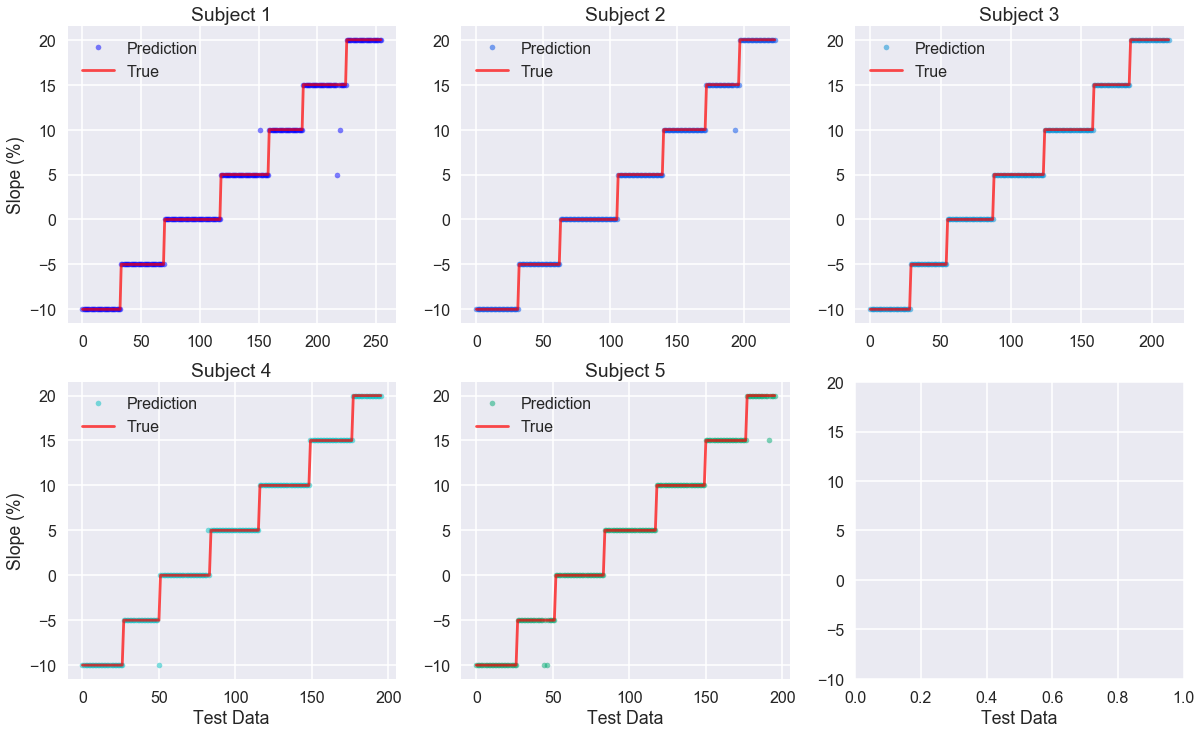

In [40]:
fig, axes = plt.subplots(2,3, figsize=(20,12))
axes = axes.flatten()

for i in range(len(X_train_list_n)):
    axes[i].plot(rf_cv_ind_list_n[i].predict(X_test_list_n[i]), '.', color= colors[i].get_rgb(), alpha = 0.5, label = 'Prediction')
    axes[i].plot(y_test_multi_list_n[i].values, 'r-', alpha = 0.7, label = 'True')
    axes[i].set_title('Subject '+str(i+1))
    axes[i].legend()



axes[3].set_xlabel("Test Data")
axes[4].set_xlabel("Test Data")
axes[5].set_xlabel("Test Data")

axes[0].set_ylabel("Slope (%)")
axes[3].set_ylabel("Slope (%)")

axes[5].set_yticks( np.unique(y_test_multi))


### 3) Regression

Table: explanation

- Baseline model: plot
- Best model: plot
- Individual Model: plots



In [32]:
linear = LinearRegression()
linear.fit(X_train, y_train_multi)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
# find number of components to explain 90% of variance

n = 200
pca = PCA(n_components=n)
pca.fit(X_train_std)
# if np.sum(pca.explained_variance_ratio_) > 0.7:
#     ninetypercent = True;
for i in range(n):
    if np.sum(pca.explained_variance_ratio_[:i]) > 0.90:
        break

ncomp = i
ncomp

pca = PCA(n_components=ncomp)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)



linear_pca = LinearRegression()
linear_pca.fit(X_train_pca, y_train_multi)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

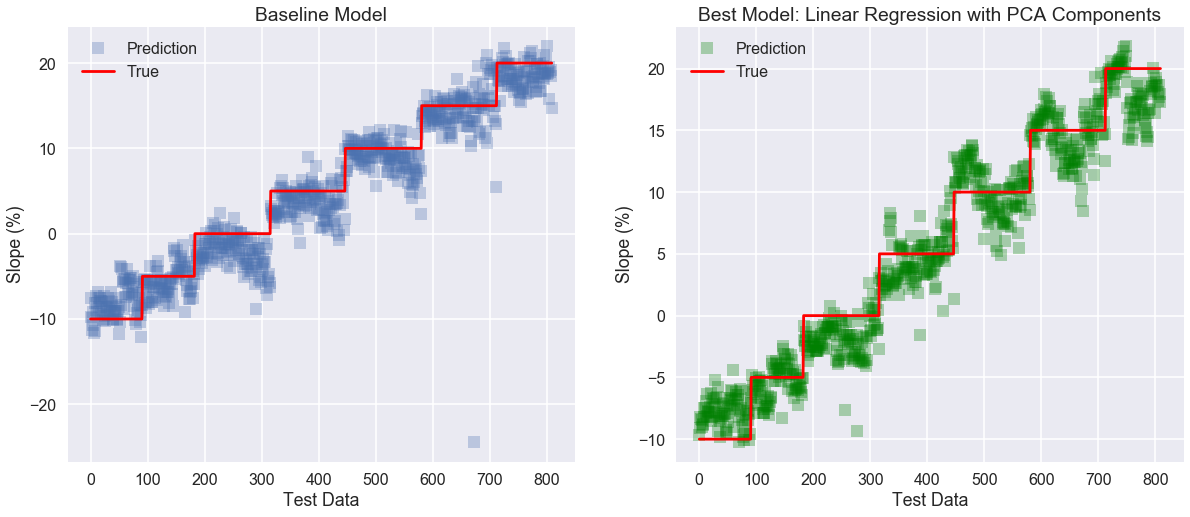

In [34]:
fig, axes = plt.subplots(1,2, figsize=(20,8))
axes = axes.flatten()

axes[0].plot(np.arange(len(y_test)), linear.predict(X_test), 's', alpha = 0.3, label = 'Prediction')
axes[0].plot(np.arange(len(y_test)), y_test_multi, 'r-', label = 'True')

axes[0].set_xlabel("Test Data")
axes[0].set_ylabel("Slope (%)")
axes[0].set_title('Baseline Model')
axes[0].legend()



axes[1].plot(np.arange(len(y_test)), linear_pca.predict(X_test_pca), 'gs', alpha = 0.3, label = 'Prediction')
axes[1].plot(np.arange(len(y_test)), y_test_multi, 'r-', label = 'True')

axes[1].set_xlabel("Test Data")
axes[1].set_ylabel("Slope (%)")
axes[1].set_title("Best Model: Linear Regression with PCA Components")
axes[1].legend()



### Individual Models: Linear Regression (PCA Components: 90% explained variance)

In [35]:
X_train_list_m, y_train_multi_list_m, X_test_list_m, y_test_multi_list_m= subject_set(X_train_pca, y_train_multi, subnum_train)


linear_pca_ind_list = [None] * len(X_train_list_m)
score_linear_pca_train_list = [None] * len(X_train_list_m)
score_linear_pca_test_list = [None] * len(X_train_list_m)

for i in range(len(X_train_list_m)):

    linear_pca_ind = LinearRegression()
    linear_pca_ind.fit(X_train_list_m[i], y_train_multi_list_m[i])

    linear_pca_ind_list[i] = linear_pca_ind
    
    score_linear_pca_train_list[i] = linear_pca_ind.score(X_train_list_m[i], y_train_multi_list_m[i])
    score_linear_pca_test_list[i]  = linear_pca_ind.score(X_test_list_m[i], y_test_multi_list_m[i])



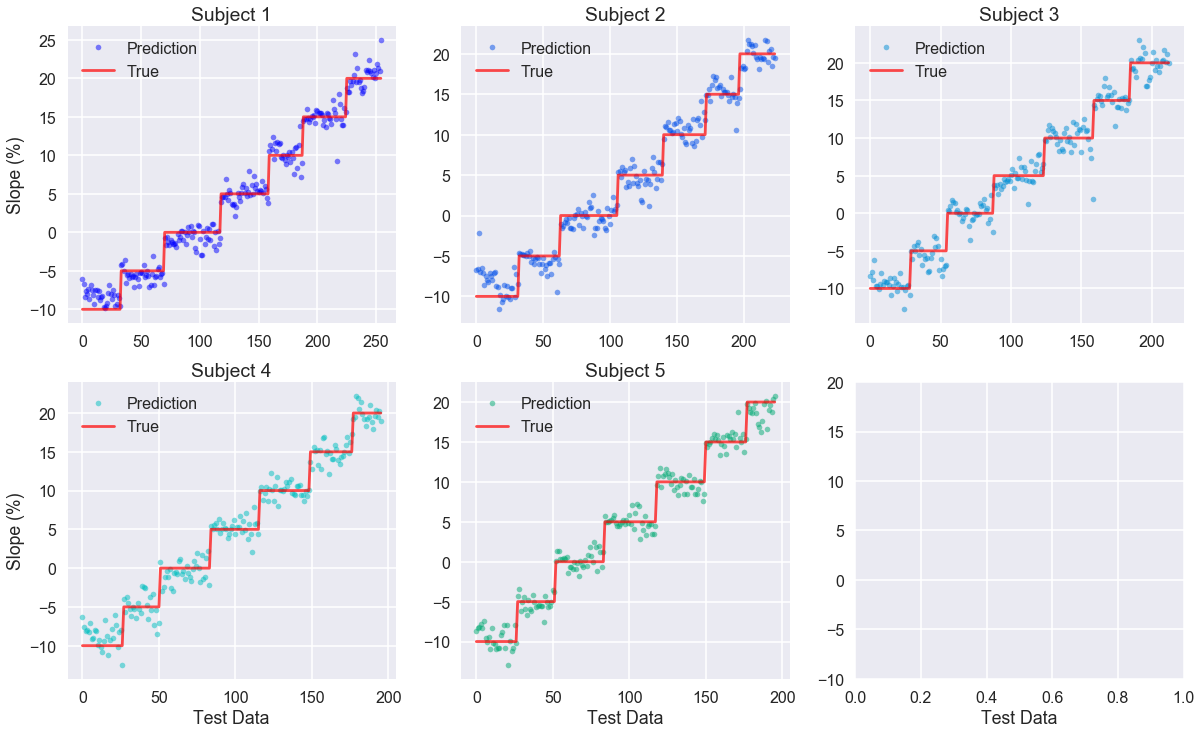

In [41]:
fig, axes = plt.subplots(2,3, figsize=(20,12))
axes = axes.flatten()

for i in range(len(X_train_list_m)):
    axes[i].plot(linear_pca_ind_list[i].predict(X_test_list_m[i]), '.', color= colors[i].get_rgb(), alpha = 0.5, label = 'Prediction')
    axes[i].plot(y_test_multi_list_m[i].values, 'r-', alpha = 0.7, label = 'True')
    axes[i].set_title('Subject '+str(i+1))
    axes[i].legend()



axes[3].set_xlabel("Test Data")
axes[4].set_xlabel("Test Data")
axes[5].set_xlabel("Test Data")

axes[0].set_ylabel("Slope (%)")
axes[3].set_ylabel("Slope (%)")
axes[5].set_yticks( np.unique(y_test_multi))



# 2. Conclusions


# 3. Futureworks